In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
data = pd.read_csv("/Users/aryanpatel/Downloads/201306-citibike-tripdata.csv")
# Remove rows with null values
data = data.dropna()
data

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,285,Broadway & E 14 St,40.734546,-73.990741,532.0,S 5 Pl & S 5 St,40.710451,-73.960876,15693,Subscriber,1991.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577687,436,2013-06-30 23:58:09,2013-07-01 00:05:25,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,403.0,E 2 St & 2 Ave,40.725029,-73.990697,19454,Subscriber,1982.0,1
577689,185,2013-06-30 23:57:52,2013-07-01 00:00:57,323,Lawrence St & Willoughby St,40.692362,-73.986317,293.0,Lafayette St & E 8 St,40.730207,-73.991026,16746,Subscriber,1982.0,1
577690,595,2013-06-30 23:58:39,2013-07-01 00:08:34,360,William St & Pine St,40.707179,-74.008873,329.0,Greenwich St & North Moore St,40.720152,-74.010365,19290,Subscriber,1985.0,1
577698,925,2013-06-30 23:59:27,2013-07-01 00:14:52,509,9 Ave & W 22 St,40.745497,-74.001971,462.0,W 22 St & 10 Ave,40.746920,-74.004519,15250,Subscriber,1964.0,1


For the cell above, I am loading in the Citibike dataset as a dataframe as well as dealing with Null Values in the dataset that would make analysis more difficult if they were not removed. Removing the Null values removed ~200000 rows. 

In [60]:
#Map numerical to categorical
map_gender = lambda x: "unknown" if x == 0 else "male" if x == 1 else "female"

# Use the apply function to apply the lambda function to the gender column
data["gender_new"] = data["gender"].apply(map_gender)


#Calculate Age using Birthyear
data['age'] = 2022 - data['birth year']

# Calculate the distance traveled using the start and end station coordinates
data['distance'] = data.apply(lambda x: geodesic((x['start station latitude'], x['start station longitude']), (x['end station latitude'], x['end station longitude'])).miles, axis=1)

# Convert the trip duration from seconds to minutes
data['tripduration_minutes'] = data['tripduration'] / 60.0

# Convert the start and end times to datetime objects
data["starttime"] = pd.to_datetime(data["starttime"])
data["stoptime"] = pd.to_datetime(data["stoptime"])

# Extract the hour 
data["start_hour"] = data["starttime"].dt.hour
data["end_hour"] = data["stoptime"].dt.hour

mapping = {'Customer': 0, 'Subscriber': 1}

# apply the mapping to the usertype column
data['usertype_num'] = data['usertype'].map(mapping)


#abs value of longitude_difference in between trip 
data["longitude_difference"] = data.apply(lambda x: abs(x["start station longitude"] - x["end station longitude"]), axis=1)

data

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,birth year,gender,gender_new,age,distance,tripduration_minutes,start_hour,end_hour,usertype_num,longitude_difference
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,...,1983.0,1,male,39.0,0.763805,11.583333,0,0,1,0.014514
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,...,1984.0,1,male,38.0,0.763805,11.550000,0,0,1,0.014514
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,...,1960.0,1,male,62.0,3.085849,2.050000,0,0,1,0.013856
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,...,1983.0,1,male,39.0,1.841887,25.350000,0,0,1,0.027648
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,285,Broadway & E 14 St,40.734546,-73.990741,532.0,S 5 Pl & S 5 St,40.710451,...,1991.0,1,male,31.0,2.285261,34.283333,0,0,1,0.029865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577687,436,2013-06-30 23:58:09,2013-07-01 00:05:25,161,LaGuardia Pl & W 3 St,40.729170,-73.998102,403.0,E 2 St & 2 Ave,40.725029,...,1982.0,1,male,40.0,0.482493,7.266667,23,0,1,0.007406
577689,185,2013-06-30 23:57:52,2013-07-01 00:00:57,323,Lawrence St & Willoughby St,40.692362,-73.986317,293.0,Lafayette St & E 8 St,40.730207,...,1982.0,1,male,40.0,2.623056,3.083333,23,0,1,0.004709
577690,595,2013-06-30 23:58:39,2013-07-01 00:08:34,360,William St & Pine St,40.707179,-74.008873,329.0,Greenwich St & North Moore St,40.720152,...,1985.0,1,male,37.0,0.898581,9.916667,23,0,1,0.001492
577698,925,2013-06-30 23:59:27,2013-07-01 00:14:52,509,9 Ave & W 22 St,40.745497,-74.001971,462.0,W 22 St & 10 Ave,40.746920,...,1964.0,1,male,58.0,0.165846,15.416667,23,0,1,0.002547


For this cell I will be doing basic data manipulation in the form of creating new columns that will be more useful for analysis

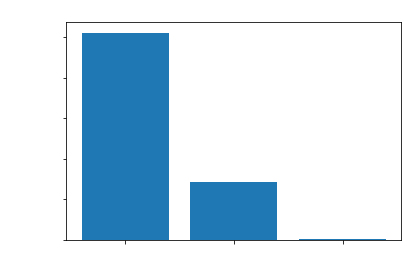

In [61]:
# Count the number of occurrences of each gender
gender_counts = data["gender_new"].value_counts()

# Get the labels and values for the bar plot
labels = gender_counts.index
values = gender_counts.values

# Create the bar plot
plt.bar(labels, values)
plt.xlabel("Gender", color='white')
plt.ylabel("Number of riders",color='white')
plt.title("Number of riders by gender",color='white')
plt.tick_params(axis='both', which='both', labelsize=10, labelcolor='white')
#Set tick label
plt.xticks(labels)


plt.show()


The cell above contains the first visualization from the dataset showing the different genders and how many rides they have had in our dataset

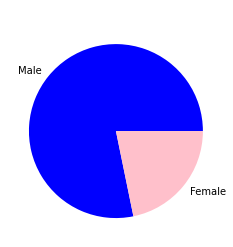

In [62]:
# Count the number of male and female riders
male_count = data[data["gender"] == 1]["gender"].count()
female_count = data[data["gender"] == 2]["gender"].count()

# Find proportion
proportions = [male_count / (male_count + female_count), female_count / (male_count + female_count)]

# Pie chart
plt.pie(proportions, labels=["Male", "Female"], colors=["blue", "pink"])
plt.title('Male vs Female Rider Proportion',color='white')
plt.show()

The cell above is a pie chart showing the proportion of Male to Female Riders

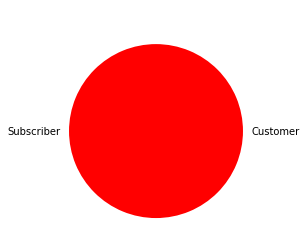

In [63]:
# Count the number of male and female riders
Subscriber_count = data[data["usertype"] == "Subscriber"]["usertype"].count()
Customer_count = data[data["usertype"] == "Customer"]["usertype"].count()

# Find proportion
proportions = [Subscriber_count / (Subscriber_count + Customer_count), Customer_count / (Subscriber_count + Customer_count)]

# Pie chart
plt.pie(proportions, labels=["Subscriber", "Customer"], colors=["red", "pink"])
plt.title('Usertype proportions (Red = subscriber)',color='white')
plt.show()

The cell above is a pie chart showing the proportion of Usertype but all of the data is showing Subscriber only. 

In [64]:
male_riders = data[data['gender_new'] == "male"]
female_riders = data[data['gender_new'] == "female"]

male_mean = male_riders['tripduration'].mean()
female_mean = female_riders['tripduration'].mean()

from scipy.stats import ttest_ind

# 2-sample t-test to determine if the means are significantly different
t_stat, p_value = ttest_ind(male_riders['tripduration'], female_riders['tripduration'])


alpha = 0.05
#print conclusion
if p_value < alpha:
    print("The means are significantly different, male riders on average have a higher trip duration than femaler riders, demonstrated by 0.05 > (p = {})".format(p_value))
else:
    print("The means are not significantly different, male and female riders on average have the same trip duration, demonstrated by 0.05 < (p = {})".format(p_value))

The means are significantly different, male riders on average have a higher trip duration than femaler riders, demonstrated by 0.05 > (p = 3.695490637214257e-19)


The cell above is a 2 sample T test. The null hypothesis of the the test is on average both male and female riders have the same trip duration. The alternative hypothesis is that male riders on average have a higher trip duration than female riders. The resulting test will conclude in a P value of p = 3.695490637214257e-19) which is very significant and smaller than our alpha so we reject the null hypothesis and can accept the alternative hypothesis. 

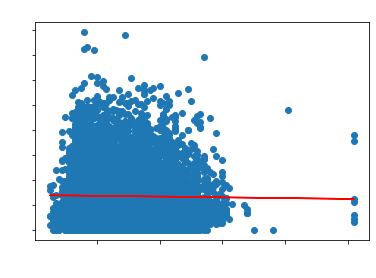

In [65]:
# Create the scatter plot
sample = data.sample(n=10000, replace=False)
plt.scatter(sample['age'], sample['distance'])

slope, intercept = np.polyfit(sample['age'],sample['distance'], 1)

plt.plot(sample['age'], slope*sample['age'] + intercept, color='red')

# labels 
plt.xlabel('Age', color='white')
plt.ylabel('Distance Traveled in Miles', color='white')
plt.title("Age versus Distance traveled",color='white')
plt.tick_params(axis='both', which='both', labelsize=10, labelcolor='white')


The cell above is a scatter plot of a sample of the full dataframe to make it viewable. It is showing Age vs distance travelled. From analysis of the visulization there does not appear to be a significant correlation between Age and Distance Travelled. A line of best fit was also added, showing a very slight decrease in most samples taken. 

In [66]:
male_riders = data[data['gender_new'] == "male"]
female_riders = data[data['gender_new'] == "female"]

male_mean = male_riders['distance'].mean()
female_mean = female_riders['distance'].mean()

from scipy.stats import ttest_ind

# 2-sample t-test to determine if the means are significantly different
t_stat, p_value = ttest_ind(male_riders['distance'], female_riders['distance'])


alpha = 0.05

if p_value < alpha:
    print("The means are significantly different, male riders on average travel a higher distance than female riders, demonstrated by 0.05 > (p = {})".format(p_value))
else:
    print("The means are not significantly different, male and female riders on average travel the same distance, demonstrated by 0.05 < (p = {})".format(p_value))

The means are significantly different, male riders on average travel a higher distance than female riders, demonstrated by 0.05 > (p = 0.010949965953349655)


The cell above is a 2 sample T test. The null hypothesis of the the test is on average both male and female riders travel the same distance. The alternative hypothesis is that male riders on average have a higher distance travelled than female riders. The resulting test will conclude in a P value of (p = 0.010949965953349655) which is significant and smaller than our alpha so we reject the null hypothesis and can accept the alternative hypothesis. 

In [67]:
X = data[['gender','age','usertype_num','birth year','start_hour',"end_hour"]]
y = data['tripduration_minutes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7)

regressor = DecisionTreeRegressor()

# Train the model on the train data
regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = regressor.predict(X_test)



mae = abs(y_test - y_pred).mean()
print(f"Mean absolute error: {mae:.2f} seconds")


Mean absolute error: 9.62 seconds


The Regression Tree above is able to predict the average trip duration in minutes with a MAE of around 9-10 seconds. 